<a href="https://colab.research.google.com/github/Khushboo-Verma2004/AI-ML-1/blob/Spotify-Heatmap/Spotify%20Recommendation/Spotify%20Playlist%20Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook shows the steps to build a recommender system using the Collaborative Filtering approach.

### The goal is to recommend artists based on user's past activity and interests of similar users.

* [Import Libraries ](#section-1)
* [Read Data](#section-2)
* [Data Prep](#section-3)
* [Recommender System](#section-4)
    - [Helper Functions](#subsection-1)
    - [Prep Model Inputs](#subsection-2)
    - [Matrix Factorization (MF) Model](#subsection-3)
    - [Evaluation Metrics](#subsection-4)
    - [Examples](#subsection-5)

<a id="section-1"></a>
# Import Libraries

In [1]:
!pip install lightfm

In [2]:
!kaggle datasets download -d ashwinik/spotify-playlist


Dataset URL: https://www.kaggle.com/datasets/ashwinik/spotify-playlist
License(s): unknown
spotify-playlist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy import sparse
import random
import lightfm
from lightfm import LightFM, cross_validation
from lightfm.evaluation import precision_at_k, auc_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

<a id="section-2"></a>
# Read Data

### The original dataset is quite large. We only read 50% of rows for faster run.

In [4]:
p = 0.50  # to randomly select 50% of the rows

In [3]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/spotify-playlist.zip'
extraction_path = '/content/spotify_data/'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# List the files to confirm extraction
extracted_files = os.listdir(extraction_path)
print(extracted_files)


['README.txt', 'spotify_dataset.csv']


In [4]:
df_playlist = pd.read_csv(os.path.join(extraction_path, 'spotify_dataset.csv'), on_bad_lines='skip', skiprows=lambda i: i > 0 and random.random() > 0.5)
# Display the first few rows of the dataframe
print(df_playlist.head())


                            user_id                      "artistname"  \
0  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello & The Attractions   
1  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello & The Attractions   
2  9cc0cfd4d7d7885102480dd99e7a90d6                            Lissie   
3  9cc0cfd4d7d7885102480dd99e7a90d6                            Lissie   
4  9cc0cfd4d7d7885102480dd99e7a90d6                    Paul McCartney   

                                         "trackname"  "playlistname"  
0  (What's So Funny 'Bout) Peace, Love And Unders...  HARD ROCK 2010  
1                              Accidents Will Happen  HARD ROCK 2010  
2                                        All Be Okay  HARD ROCK 2010  
3                                        Bright Side  HARD ROCK 2010  
4                                      Dance Tonight  HARD ROCK 2010  


### Size of dataframe

In [7]:
df_playlist.shape

(6447143, 4)

### Clean up column names

In [5]:
df_playlist.columns = df_playlist.columns.str.replace('"', '')
df_playlist.columns = df_playlist.columns.str.replace('name', '')
df_playlist.columns = df_playlist.columns.str.replace(' ', '')
df_playlist.columns

Index(['user_id', 'artist', 'track', 'playlist'], dtype='object')

In [9]:
# CHECKING FOR MISSING VALUES
df_playlist.isnull().sum()

,0
user_id,0
artist,16887
track,44
playlist,662


In [6]:
#DROPPING MISSING VALUES
df_playlist.dropna(axis = 0, inplace = True, subset = ['user_id','artist','track','playlist'])

<a id="section-3"></a>
# Data Prep

#### For recommender system, We are only keeping the artists with frequency higher than 50

In [11]:
df_playlist = df_playlist.groupby('artist').filter(lambda x : len(x)>=50)

KeyboardInterrupt: 

#### And keeping the users with at least 10 unique artists in their playlists to lessen the impact of cold start problem

In [ ]:
df_playlist = df_playlist[df_playlist.groupby('user_id').artist.transform('nunique') >= 10]

#### Group by to get the frequnecy count for each user and artist (# of times that an artist has appeared in playlists created by a user)

In [ ]:
size = lambda x: len(x)
df_freq = df_playlist.groupby(['user_id', 'artist']).agg('size').reset_index().rename(columns={0:'freq'})[['user_id', 'artist', 'freq']].sort_values(['freq'], ascending=False)
df_freq.head()

### create a DF for artists and add artist id

In [ ]:
df_artist = pd.DataFrame(df_freq["artist"].unique())
df_artist = df_artist.reset_index()
df_artist = df_artist.rename(columns={'index':'artist_id', 0:'artist'})
df_artist.head()

In [ ]:
df_artist.shape

### add artist_id to the main DF

In [ ]:
df_freq  = pd.merge(df_freq , df_artist, how='inner', on='artist')

In [ ]:
df_playlist.shape

In [ ]:
#Categorize users into "New" and "Frequent" based on the number of tracks added and compare their activity levels
user_activity = df_playlist.groupby('user_id').size().reset_index(name='tracks_added')
threshold = 100
user_activity['user_category'] = user_activity['tracks_added'].apply(lambda x: 'Frequent' if x >= threshold else 'New')
print(user_activity.head())


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
threshold = user_activity['tracks_added'].quantile(0.75)
user_activity['user_category'] = user_activity['tracks_added'].apply(lambda x: 'Frequent' if x >= threshold else 'New')
activity_comparison = user_activity.groupby('user_category')['tracks_added'].mean().reset_index()
plt.figure(figsize=(6, 4))
plt.bar(activity_comparison['user_category'], activity_comparison['tracks_added'], color=['blue', 'orange'])
plt.title('Comparison of Activity Levels: New vs. Frequent Users')
plt.xlabel('User Category')
plt.ylabel('Average Number of Tracks Added')
plt.show()


## Collaborative Filtering

**Collaborative filtering** is a technique used to make personalized suggestions based on user preferences.
User's behaviour information is collected and their future preferences are predicted by analyzing this data. One can notice this when Spotify manages to find new music of your taste.

* **You** and **Alice** have similar tastes, both liking Pop Band X and Rock band Y.
* **Alice** likes New Indie Band Z.
* The algorithm predicts you might also like Indie Band Z because you and Alice have similar tastes.

##Different Types of Collaborative Filtering:**

* **User-based:**  Finds users similar to you and recommends what they like.  (Like the example above).
* **Item-based:**  Finds items (songs/artists) that are similar to what you've liked and recommends those. For example, if you like Song A, and many other users who like Song A also like Song B, then Song B might be recommended to you.


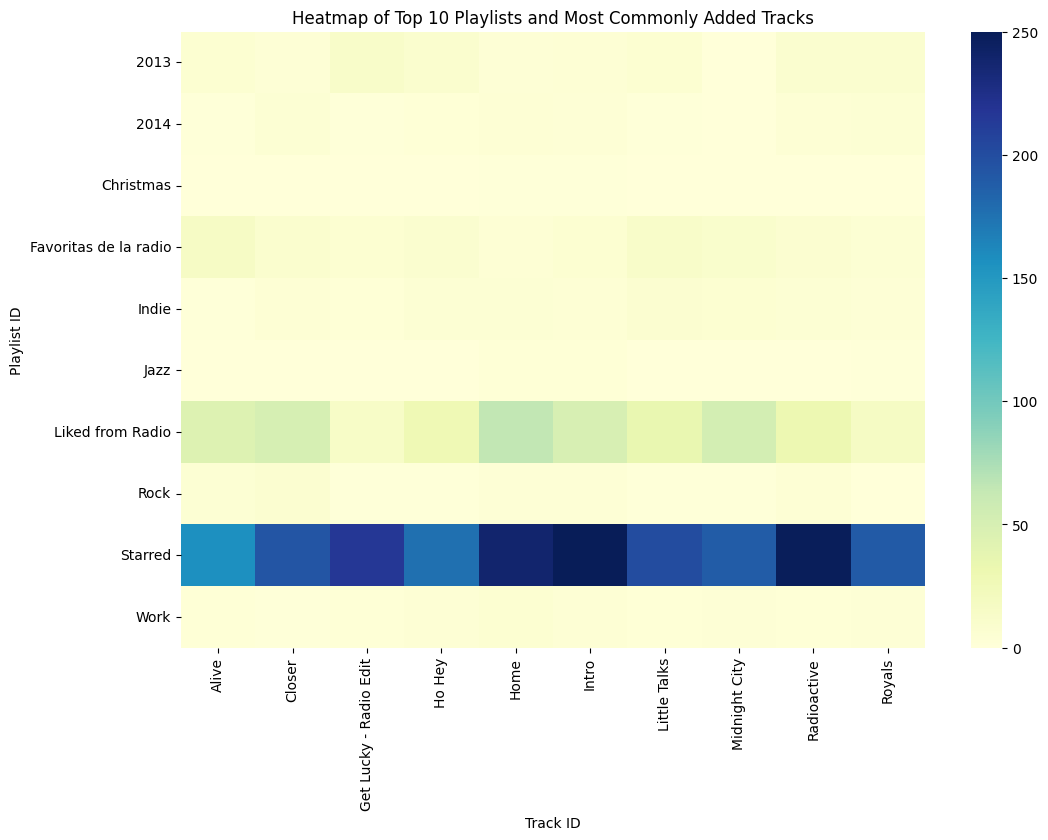

In [9]:
top_playlists = df_playlist['playlist'].value_counts().head(10).index
top_tracks = df_playlist[df_playlist['playlist'].isin(top_playlists)]['track'].value_counts().head(10).index
filtered_df = df_playlist[df_playlist['playlist'].isin(top_playlists) & df_playlist['track'].isin(top_tracks)]
pivot_table = filtered_df.pivot_table(index='playlist', columns='track', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=False, fmt='d', cbar=True)
plt.title('Heatmap of Top 10 Playlists and Most Commonly Added Tracks')
plt.xlabel('Track ID')
plt.ylabel('Playlist ID')
plt.show()


<a id="section-4"></a>
# Recommender System

#### We are using the LightFM library and run a traditional MF model since the dataset doesn't include any user or artist features,


<a id="subsection-1"></a>
## Helper Functions

In [ ]:
def create_interaction_matrix(df,user_col, item_col, rating_col, norm= False, threshold = None):
    '''
    Function to create an interaction matrix dataframe from transactional type interactions
    Required Input -
        - df = Pandas DataFrame containing user-item interactions
        - user_col = column name containing user's identifier
        - item_col = column name containing item's identifier
        - rating col = column name containing user feedback on interaction with a given item
        - norm (optional) = True if a normalization of ratings is needed
        - threshold (required if norm = True) = value above which the rating is favorable
    Expected output -
        - Pandas dataframe with user-item interactions ready to be fed in a recommendation algorithm
    '''
    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [ ]:
def create_user_dict(interactions):
    '''
    Function to create a user dictionary based on their index and number in interaction dataset
    Required Input -
        interactions - dataset create by create_interaction_matrix
    Expected Output -
        user_dict - Dictionary type output containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [ ]:
def create_item_dict(df,id_col,name_col):
    '''
    Function to create an item dictionary based on their item_id and item name
    Required Input -
        - df = Pandas dataframe with Item information
        - id_col = Column name containing unique identifier for an item
        - name_col = Column name containing name of the item
    Expected Output -
        item_dict = Dictionary type output containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

In [ ]:
def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30,n_jobs = 4):
    '''
    Function to run matrix-factorization algorithm
    Required Input -
        - interactions = dataset create by create_interaction_matrix
        - n_components = number of embeddings you want to create to define Item and user
        - loss = loss function other options are logistic, brp
        - epoch = number of epochs to run
        - n_jobs = number of cores used for execution
    Expected Output  -
        Model - Trained model
    '''

    #uncommented for train test split
#     x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    return model

In [ ]:
def sample_recommendation_user(model, interactions, user_id, user_dict,
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    '''
    Function to produce user recommendations
    Required Input -
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - user_id = user ID for which we need to generate recommendation
        - user_dict = Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - threshold = value above which the rating is favorable in new interaction matrix
        - nrec_items = Number of output recommendation needed
    Expected Output -
        - Prints list of items the given user has already bought
        - Prints list of N recommended items  which user hopefully will be interested in
    '''
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index) \
								 .sort_values(ascending=False))

    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list

<a id="subsection-2"></a>
## Prep Model Inputs

### Create interaction matrix

In [ ]:
interactions = create_interaction_matrix(df = df_freq, user_col = "user_id", item_col = 'artist_id', rating_col = 'freq', norm= False, threshold = None)
interactions.head()

In [ ]:
interactions.shape

### Create User Dict

In [ ]:
user_dict = create_user_dict(interactions=interactions)

### Create Item dict

In [ ]:
artists_dict = create_item_dict(df = df_artist, id_col = 'artist_id', name_col = 'artist')

### Train-Test split

In [ ]:
x = sparse.csr_matrix(interactions.values)
train, test = lightfm.cross_validation.random_train_test_split(x, test_percentage=0.2, random_state=None)

<a id="subsection-3"></a>
## Matrix Factorization (MF) Model

### Train the Matrix Factorization Model

In [ ]:
%time
model = runMF(interactions = train,
                 n_components = 30,
                 loss = 'warp',
                 k = 15,
                 epoch = 30,
                 n_jobs = 4)

#### We can do hyper-parameter tuning for better results

<a id="subsection-4"></a>
## Evaluation Metrics

 ### Compute AUC score for Train set

In [ ]:
train_auc = auc_score(model, train, num_threads=4).mean()
print('Train AUC: %s' % train_auc)

### Compute AUC score for Test set

#### The parameter train_interactions allows us to exclude known positives in training set from the predicitons and score calculations.
#### This is to avoid re-recommending the items the user has alreardy interacted with

In [ ]:
test_auc = auc_score(model, test, train_interactions=train, num_threads=4).mean()
print('Test AUC: %s' % test_auc)

### Compute Precision scores
#### Precision score is based on the number of positives items in the K highest ranked items.

In [ ]:
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

In [ ]:
print('train Precision %.2f, test Precision %.2f.' % (train_precision, test_precision))

<a id="subsection-5"></a>
## Examples

### Let's see some examples of recommendations:

In [ ]:
rec_list = sample_recommendation_user(model = model,
                                      interactions = interactions,
                                      user_id = '9cc0cfd4d7d7885102480dd99e7a90d6',
                                      user_dict = user_dict,
                                      item_dict = artists_dict,
                                      threshold = 0,
                                      nrec_items = 10,
                                      show = True)

In [ ]:
rec_list = sample_recommendation_user(model = model,
                                      interactions = interactions,
                                      user_id = 'ffe32d5412269f3041c58cbf0dde3306',
                                      user_dict = user_dict,
                                      item_dict = artists_dict,
                                      threshold = 0,
                                      nrec_items = 10,
                                      show = True)

Analysis and Visualization Tasks

In [ ]:
#TODO Create a histogram showing the distribution of the number of tracks added by each user.
import matplotlib.pyplot as plt
track_counts = df_playlist.groupby('user_id').size()
print(track_counts.describe())  # Check the statistical summary

In [ ]:
#plotting a histogram with original data
plt.figure(figsize=(10,10))
plt.hist(track_counts, bins=50, color='skyblue')
max_tracks = track_counts.max()
plt.title('Distribution of Number of Tracks Added by Each User')
plt.xlabel('Number of Tracks')
plt.ylabel('Number of Users')
plt.show()

In [ ]:
#this graph shows that the data is skewed and thus we need to scale it thus used logarithmic scaling
log_data = np.log10(track_counts)

# Plot the histogram of the transformed data
plt.figure(figsize=(12, 6))
plt.hist(log_data, bins=50, color='skyblue', alpha=0.8)

# Customize labels and title
plt.title('Log-Transformed Histogram of Number of Tracks Added by Users')
plt.xlabel('Log10(Number of Tracks)')
plt.ylabel('Frequency')

# Add gridlines for better readability
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

In [ ]:
#TODO Create a bar plot showing the top 10 most popular artists based on the number of times they appear in playlists.

import matplotlib as plt

artist_counts = df_playlist['artistname'].value_counts()

# Get the top 10 artists
top_artists = artist_counts.head(10)

# Plot the data
plt.figure(figsize=(10, 6))
top_artists.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Top 10 Most Popular Artists Based on Playlist Appearances', fontsize=14)
plt.xlabel('Artist Name', fontsize=12)
plt.ylabel('Number of Appearances', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#TODO Create a bar plot showing the top 10 most popular tracks based on frequency in playlists.

track_counts = df_playlist['trackname'].value_counts()

# Get the top 10 tracks
top_tracks = track_counts.head(10)

# Plot the data
plt.figure(figsize=(10, 6))
top_tracks.plot(kind='bar', color='orange', edgecolor='black')

plt.title('Top 10 Most Popular Tracks Based on Playlist Appearances', fontsize=14)
plt.xlabel('Track Name', fontsize=12)
plt.ylabel('Number of Appearances', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#TODO Create a visualization showing the number of unique artists in each playlist.
import matplotlib.pyplot as plt

# Count unique artists per playlist
unique_artists_per_playlist = df_playlist.groupby('playlist')['artist'].nunique()

# Plot the data
plt.figure(figsize=(20, 8))
unique_artists_per_playlist.sort_values(ascending=False).head(50).plot(kind='bar', color='purple', edgecolor='black')

plt.title('Playlists with Most Unique Artists', fontsize=14)
plt.xlabel('Playlist Name', fontsize=12)
plt.ylabel('Number of Unique Artists', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#TODO Create a heatmap or pivot table showing the relationship between playlists and their most commonly added tracks.

In [ ]:
#TODO Display a summary of the dataset, including total users, artists, tracks, and playlists.

In [ ]:
#TODO Display a summary of the dataset, including total users, artists, tracks, and playlists.

In [ ]:
#TODO Check for and handle missing values in the dataset.

In [ ]:
#TODO Add a markdown cell explaining collaborative filtering concepts in simple terms with examples.

### Understanding Collaborative Filtering

Collaborative Filtering is a popular technique used in recommender systems to suggest items (like songs, movies, or products) based on user preferences and the behavior of similar users. 

#### How It Works:
1. **User-Based Collaborative Filtering**: 
   - Finds users with similar preferences and recommends items they liked.
   - Example: If Alice and Bob both like Artist X and Y, but Alice also likes Artist Z, Bob might receive a recommendation for Artist Z.

2. **Item-Based Collaborative Filtering**:
   - Finds similar items based on user interactions.
   - Example: If many users who listen to Song A also listen to Song B, then Song B will be recommended to new listeners of Song A.

#### Advantages:
- Works without requiring detailed information about songs or users.
- Learns from real user behavior.

#### Limitations:
- Struggles with new users or songs (cold start problem).
- Requires a large amount of user interaction data.

Collaborative Filtering is widely used in platforms like **Spotify, Netflix, and Amazon** to enhance user experience with personalized recommendations.

In [86]:
#TODO Compare multiple evaluation metrics (e.g., precision, recall, and F1-score) in a single table or plot.
!pip install lightfm scikit-learn
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from sklearn.metrics import f1_score
import pandas as pd


In [87]:
#TODO Compare multiple evaluation metrics (e.g., precision, recall, and F1-score) in a single table or plot.

# Calculate recall at k for train and test sets
train_recall = recall_at_k(model, train, k=10).mean()
test_recall = recall_at_k(model, test, k=10, train_interactions=train).mean()

# Since LightFM doesn't directly provide F1-score, we need to get predictions first
# and then use sklearn's f1_score. This is a simplified approach for demonstration.
# In real-world scenarios, you'd need to carefully consider the threshold for binary classification.

# Get predictions for train and test sets
train_predictions = model.predict(train.row, train.col)
test_predictions = model.predict(test.row, test.col)

# Assume a threshold of 0 to convert predictions to binary (0 or 1)
train_predictions_binary = (train_predictions > 0).astype(int)
test_predictions_binary = (test_predictions > 0).astype(int)

# Calculate F1-score for train and test sets
# Note: We're using micro averaging here. Explore other options if needed.
train_f1 = f1_score(train.data, train_predictions_binary, average='micro')
test_f1 = f1_score(test.data, test_predictions_binary, average='micro')

# Create a comparison table
data = {'Metric': ['Precision', 'Recall', 'F1-Score', 'AUC'],
        'Train': [train_precision, train_recall, train_f1, train_auc],
        'Test': [test_precision, test_recall, test_f1, test_auc]}
df_metrics = pd.DataFrame(data)

# Display the table
display(df_metrics)

,Metric,Train,Test
0,Precision,0.592627,0.398131
1,Recall,0.227049,0.484685
2,F1-Score,0.039936,0.043005
3,AUC,0.941143,0.956639
